# FashionMNIST classification

In this notebook, I'm going to implement two different classifier models on the **FashionMNIST** dataset. so this notebook mainly contains two parts, the first part includes implementing a Convolutional Neural Network with two Convolution blocks and one fully connected layer at the end, in the second part, I'm using the **transfer learning** technique to retrain the pre-trained `resnet50` model on FashionMNIST dataset. As expected, the second method achieves more accuracy on both train and test datasets.

In [201]:
import torch
from torch import nn


import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision import models
from torchvision.transforms import ToTensor

from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

from tqdm.auto import tqdm

plt.style.use('ggplot')

In [2]:
DATA_PATH = 'D:\PyTorch_datasets'
BATCH_SIZE = 32

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
train_data = datasets.FashionMNIST(
    root=DATA_PATH,
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root=DATA_PATH,
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

In [4]:
len(train_data), len(test_data)

(60000, 10000)

In [5]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

### DataLoader

In [8]:
train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

In [21]:
train_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: D:\PyTorch_datasets
    Split: Train
    StandardTransform
Transform: ToTensor()

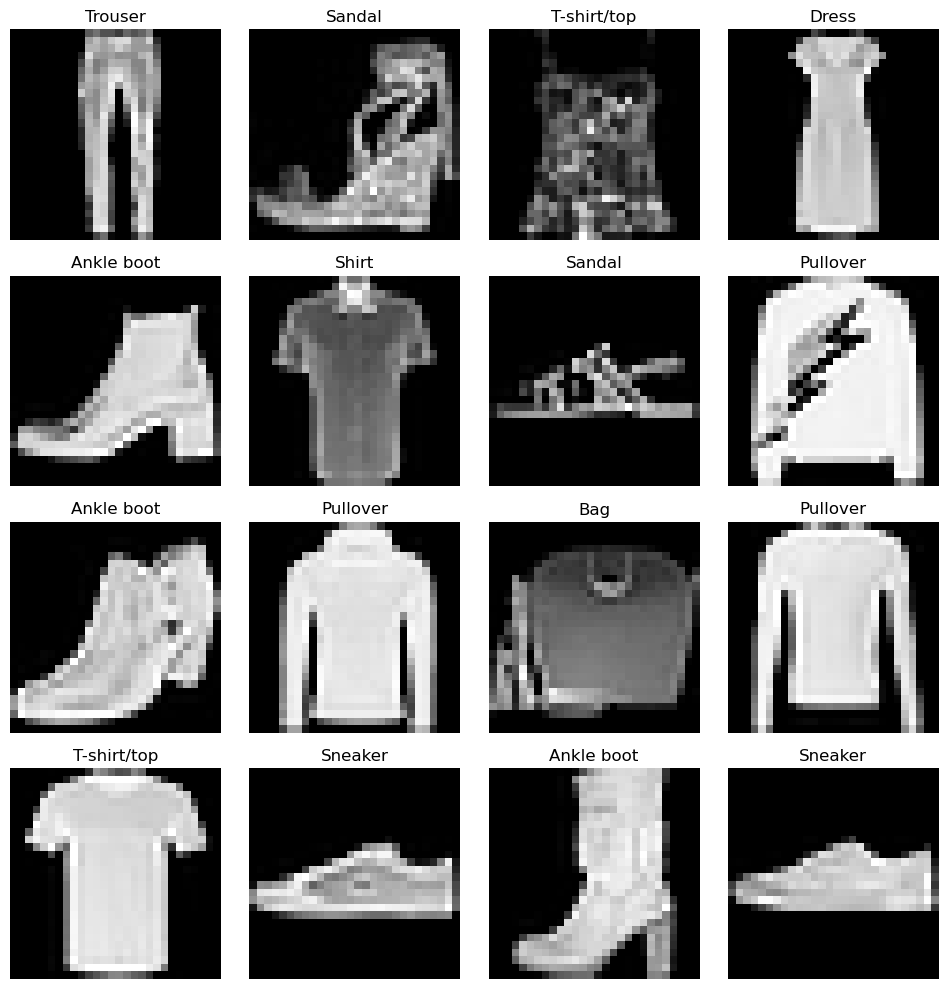

In [11]:
plt.figure(figsize=(10, 10))
rows = 4
columns = 4
for i in range(columns):
    for j in range(rows):
        plt.subplot(rows, columns, i*rows+j+1)
        plt.imshow(one_batch_features[i*rows+j].squeeze(), cmap='gray')
        plt.title(class_names[one_batch_labels[i*rows+j]])
        plt.axis('off')
        plt.tight_layout()

## The first part implementation

In [207]:
class Classifier(nn.Module):
    def __init__(self, in_channels, hidden_units, out_classes):
        super().__init__()
        self.conv_01 = nn.Sequential(
            nn.Conv2d(in_channels=input_features, out_channels=hidden_units, kernel_size=(3, 3), stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=(3, 3), stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=(2, 2))            
        ) 
        
        self.conv_02 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=(3, 3), stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=(3, 3), stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=(2, 2))
        )
        
        self.Dense_Layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 7 * 7, out_features=out_classes)
        )
        
    def forward(self, x):
        x = self.conv_01(x)
        x = self.conv_02(x)
        x = self.Dense_Layer(x)
        return x

In [92]:
torch.manual_seed(2)

model = Classifier(input_features = 1, hidden_units=10, output_classes=len(class_names)).to(device)

In [93]:
loss_function = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

In [94]:
def train_epoch(model, data_loader, loss_function, optimizer, device = device):

    train_loss, train_acc = 0, 0

    model.train()

    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        
        y_pred = model(X)
        
        loss = loss_function(y_pred, y)
        train_loss += loss    
        
        predicted_labels = torch.softmax(y_pred, dim=1).argmax(dim=1)
        correct = torch.eq(y, predicted_labels).sum().item()
        train_acc += (correct / len(predicted_labels)) * 100

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)

    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

In [95]:
def test_epoch(model, data_loader, loss_fn, device=device):
    
    test_loss, test_acc = 0, 0
    
    model.eval()
    
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            
            test_pred = model(X)
            predicted_labels = torch.softmax(test_pred, dim=1).argmax(dim=1)
            correct = torch.eq(y, predicted_labels).sum().item()
            test_acc += (correct / len(predicted_labels)) * 100
            
            
            test_loss += loss_fn(test_pred, y)
            
            
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [96]:
epochs = 8

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    train_epoch(model, train_dataloader, loss_function, optimizer, device=device)
    test_epoch(model, train_dataloader, loss_function, device=device)

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 0
-------
Train loss: 0.66231 | Train accuracy: 75.74%
Test loss: 0.36285 | Test accuracy: 87.00%

Epoch: 1
-------
Train loss: 0.34894 | Train accuracy: 87.58%
Test loss: 0.32814 | Test accuracy: 88.29%

Epoch: 2
-------
Train loss: 0.31429 | Train accuracy: 88.72%
Test loss: 0.30628 | Test accuracy: 88.94%

Epoch: 3
-------
Train loss: 0.29647 | Train accuracy: 89.33%
Test loss: 0.26730 | Test accuracy: 90.39%

Epoch: 4
-------
Train loss: 0.28410 | Train accuracy: 89.79%
Test loss: 0.28007 | Test accuracy: 89.92%

Epoch: 5
-------
Train loss: 0.27610 | Train accuracy: 89.99%
Test loss: 0.27767 | Test accuracy: 89.79%

Epoch: 6
-------
Train loss: 0.26820 | Train accuracy: 90.24%
Test loss: 0.25421 | Test accuracy: 90.59%

Epoch: 7
-------
Train loss: 0.26373 | Train accuracy: 90.40%
Test loss: 0.25985 | Test accuracy: 90.55%



In [113]:
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [235]:
def plot_label_probs(model, num_of_images=7, data=train_data):
    torch.manual_seed(1)
    num_of_images = 7
    random_indices = torch.randint(len(data), (num_of_images,))

    fig, ax = plt.subplots(num_of_images, 2, figsize=(25,25), gridspec_kw={'width_ratios': [4, 1]})

    for i in range(num_of_images):
        model.eval()
        with torch.inference_mode():
            probs = model(data[random_indices[i]][0].unsqueeze(dim=0).to(device))

        ax[i][0].imshow(data[random_indices[i]][0].squeeze(), cmap='gray')
        ax[i][0].axis('off')
        barlist = ax[i][1].barh(class_names, np.exp(probs.squeeze().cpu().numpy()))
        ax[i][1].set_xticks([])
        barlist[data[random_indices[i]][1]].set_color('g')

        plt.tight_layout()

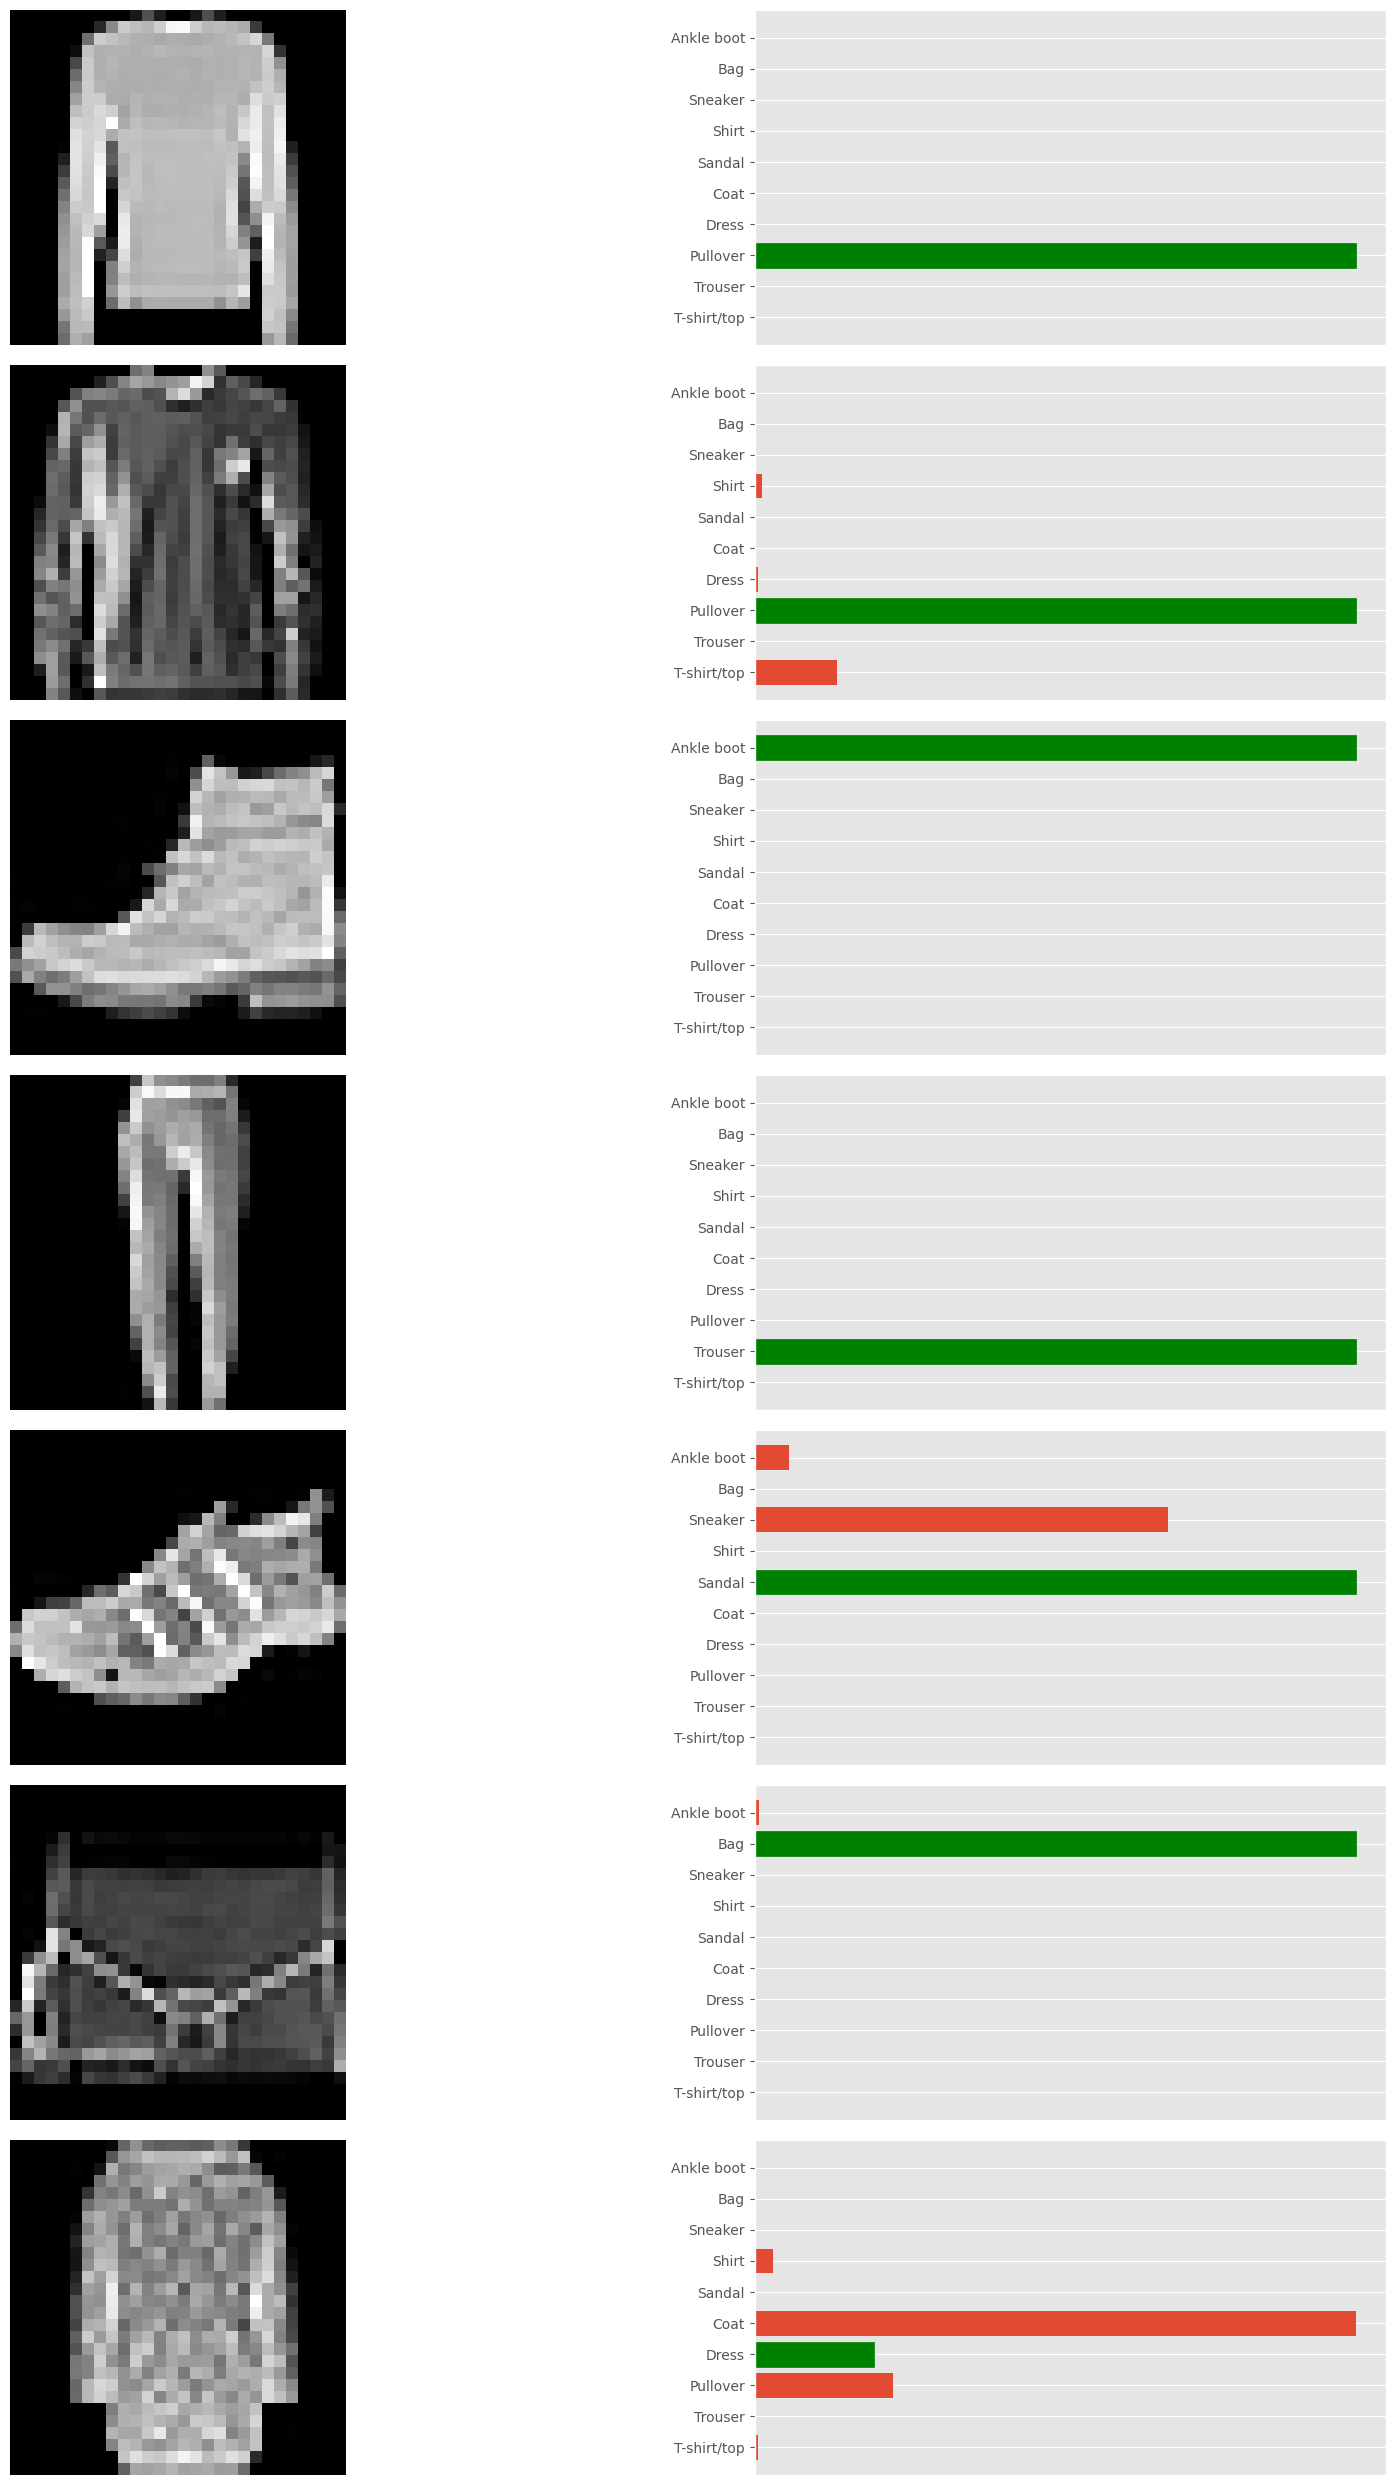

In [236]:
plot_label_probs(model, data=train_data)

## Second part: Using Transfer Learning on `resnet50`

In [211]:
class ResNetClassifier(nn.Module):
    def __init__(self, in_channels=1, out_classes=10):
        super().__init__()

        self.model = models.resnet50(pretrained=True)
        self.model.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)

        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, out_classes)

    def forward(self, x):
        return self.model(x)


resnet_model = ResNetClassifier().to(device)

In [231]:
resnet_model = ResNetClassifier().to(device)
resnet_loss_function = nn.CrossEntropyLoss()
resnet_optimizer = torch.optim.SGD(params=resnet_model.parameters(), lr=0.002, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=resnet_optimizer, step_size=2, gamma=0.9)

epochs = 10

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")
    train_epoch(resnet_model, train_dataloader, resnet_loss_function, resnet_optimizer, device=device)
    scheduler.step()
    test_epoch(resnet_model, train_dataloader, resnet_loss_function, device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
-------
Train loss: 0.49153 | Train accuracy: 82.53%
Test loss: 0.31189 | Test accuracy: 88.30%

Epoch: 1
-------
Train loss: 0.29732 | Train accuracy: 89.09%
Test loss: 0.22095 | Test accuracy: 92.05%

Epoch: 2
-------
Train loss: 0.24055 | Train accuracy: 90.94%
Test loss: 0.19030 | Test accuracy: 92.84%

Epoch: 3
-------
Train loss: 0.21392 | Train accuracy: 92.16%
Test loss: 0.15627 | Test accuracy: 94.12%

Epoch: 4
-------
Train loss: 0.17942 | Train accuracy: 93.27%
Test loss: 0.13845 | Test accuracy: 94.88%

Epoch: 5
-------
Train loss: 0.16020 | Train accuracy: 93.98%
Test loss: 0.11933 | Test accuracy: 95.59%

Epoch: 6
-------
Train loss: 0.13465 | Train accuracy: 94.88%
Test loss: 0.12044 | Test accuracy: 95.37%

Epoch: 7
-------
Train loss: 0.12130 | Train accuracy: 95.33%
Test loss: 0.08200 | Test accuracy: 97.04%

Epoch: 8
-------
Train loss: 0.10127 | Train accuracy: 96.26%
Test loss: 0.06287 | Test accuracy: 97.68%

Epoch: 9
-------
Train loss: 0.09294 | Train a

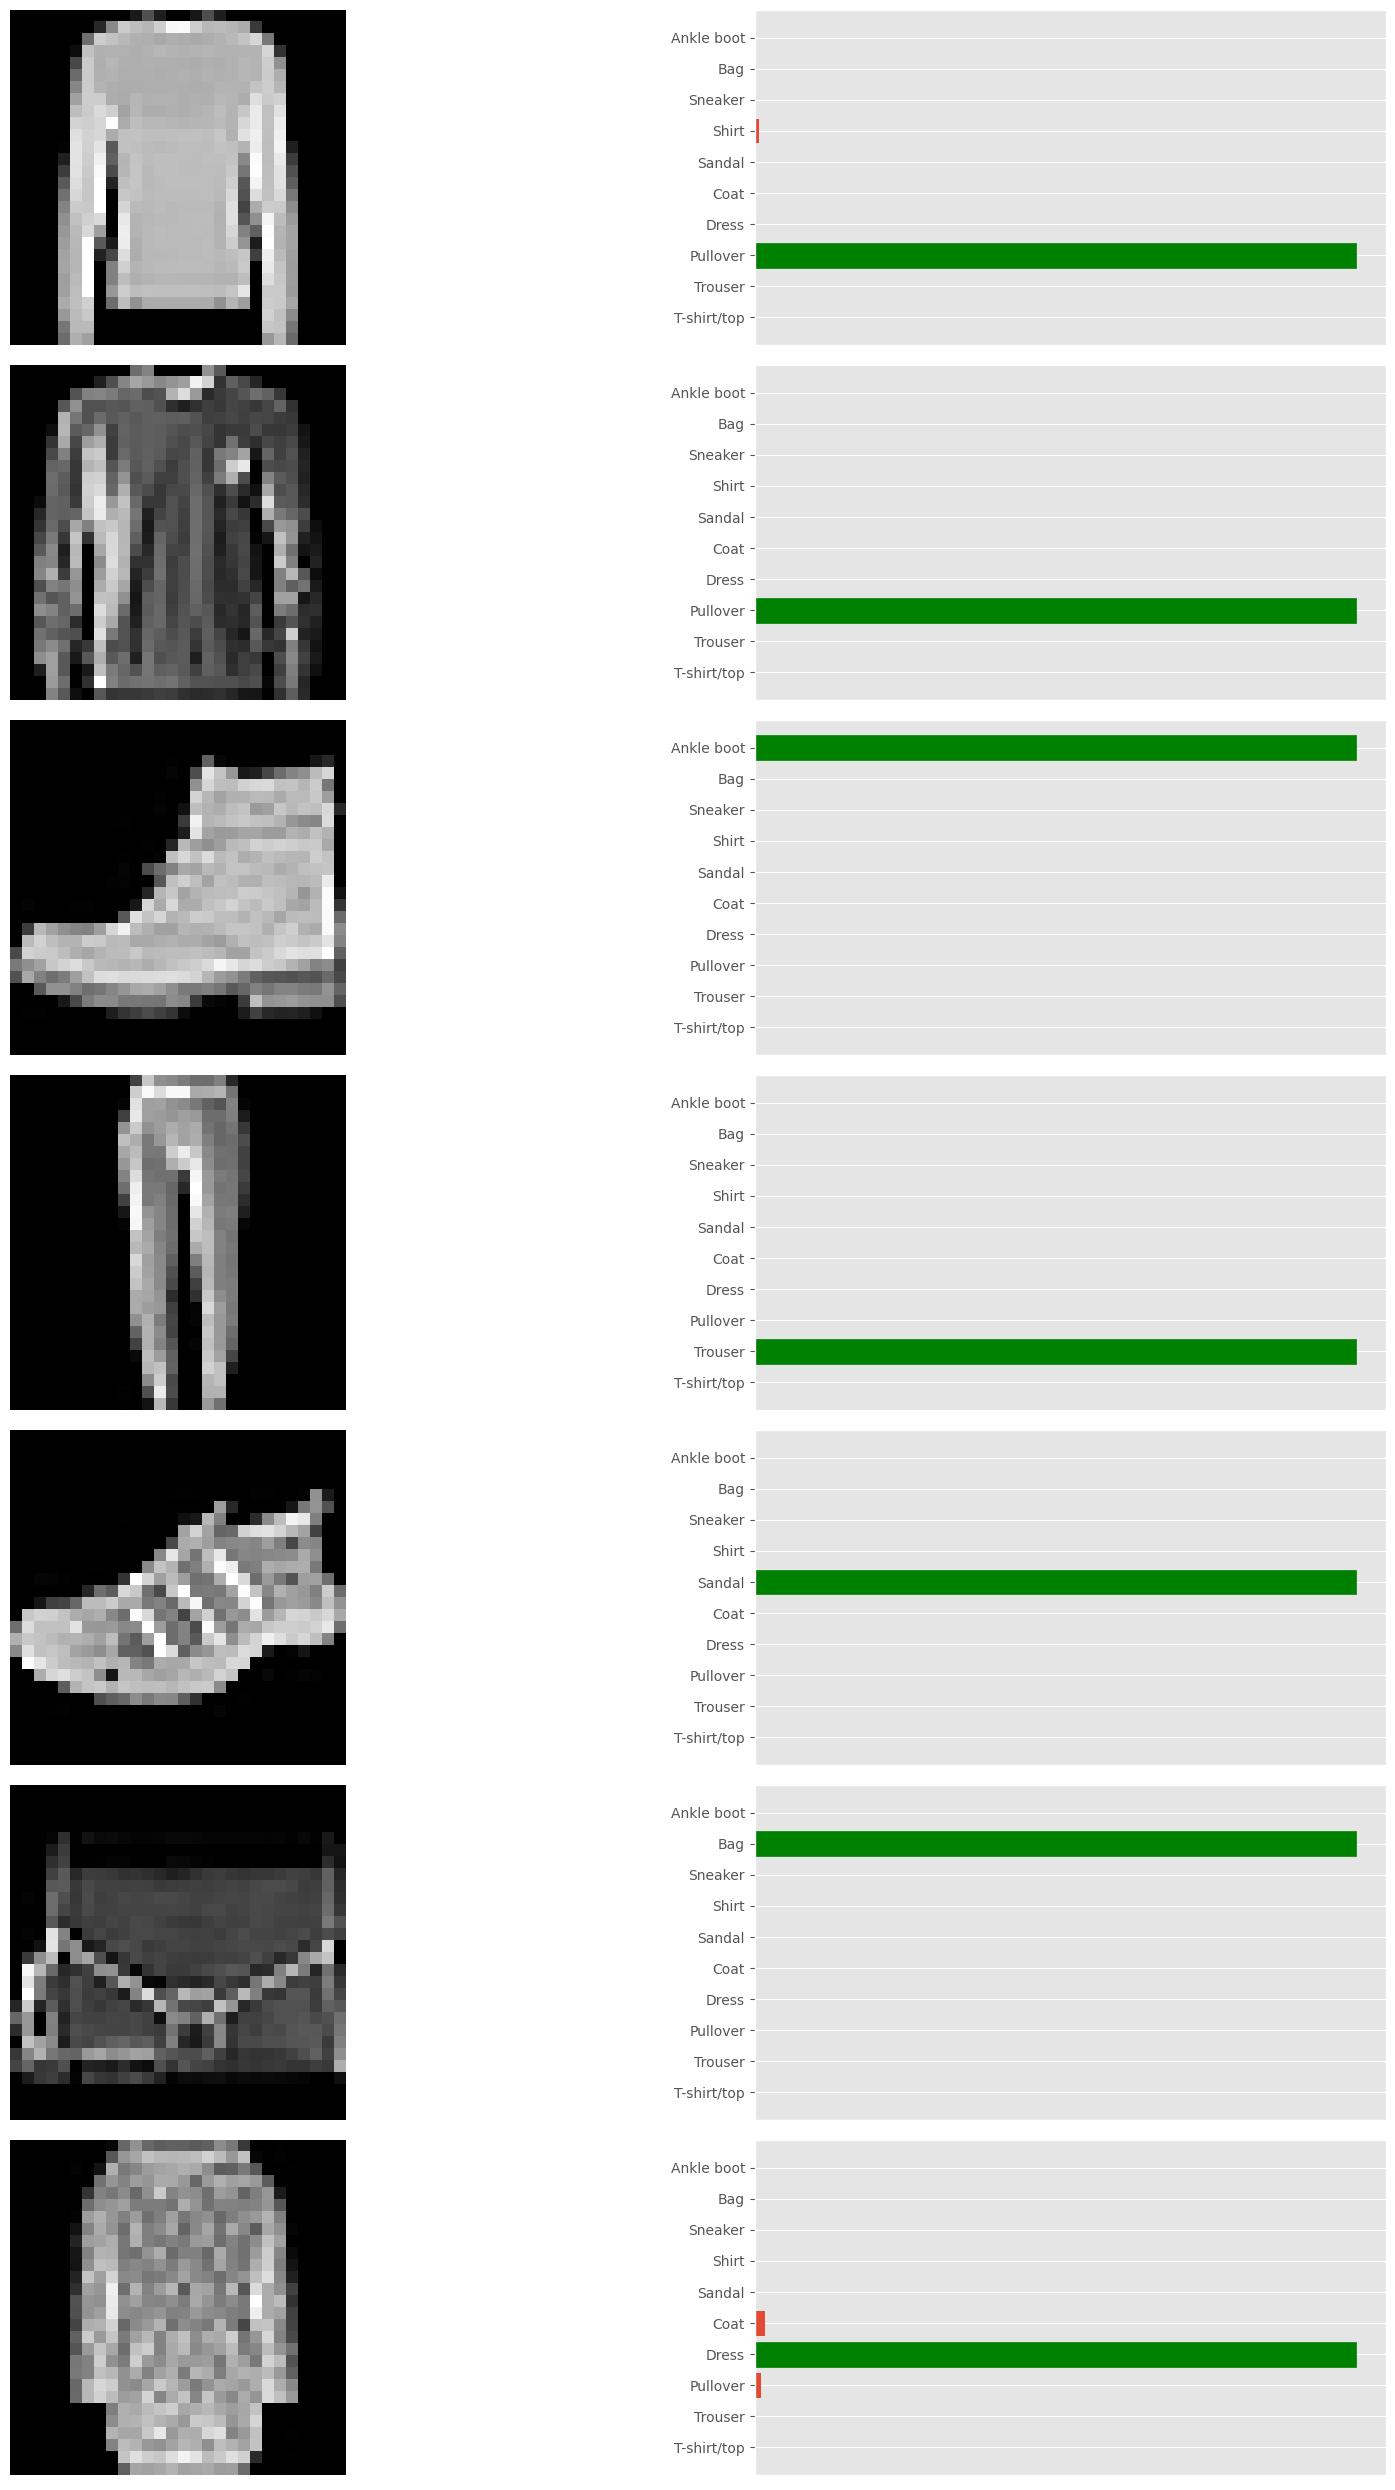

In [237]:
plot_label_probs(resnet_model, data=train_data)